<span class='main_title'>NPL - Machine Learning</span>
<hr>
<span class='author'>author:<a href='github.com/baiochi'>@baiochi<span>

# Notebook Configuration

## Dependencies

In [1]:
# Install spacy and download portuguese model
# !pip install -U spacy
# !python -m spacy download pt_core_news_md

## Libraries and APIs

In [2]:
# Terminal ASCII colors
WHITE = '\033[39m'; CYAN  = '\033[36m'; ORANGE = '\033[93m';
# Image drawing colors
BLUE   = '#00fafd'    # rgb(0,250,253)
YELLOW = '#f5b324'    # rgb(245,179,36)
# Styling notebook with CSS
from IPython.core.display import HTML
styles = open("./styles/custom.css", "r").read()
HTML(styles)

In [3]:
# Data manipulation
from collections import Counter
from unidecode import unidecode
from datetime import datetime as dt
import re
import numpy as np
import pandas as pd

# NPL
import nltk
import spacy
import emoji

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud

# Progress bar
from tqdm import tqdm; tqdm.pandas();

# Supress useless warnings
import warnings

import os

# Plot colors
URBAN_PALETTE = pd.DataFrame({
    'cyan'    : '#1696d2',
    'gray'    : '#d2d2d2',
    'black'   : '#000000',
    'yellow'  : '#fdbf11',
    'magenta' : '#ec008b',
    'green'   : '#55b748',
    'red'     : '#db2b27',
}, index=['hex_code'])

In /Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/baiochi/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/baiochi/opt/anaconda3/lib/

## Functions

### Classification metrics

In [4]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,\
                            confusion_matrix, classification_report, roc_auc_score, \
                            auc, f1_score, roc_curve, plot_roc_curve, precision_recall_curve
from sklearn.preprocessing import label_binarize

# Generate a Plotly figure to plot Confusion Matrix
def create_confusion_matrix(y_true, y_pred, target_labels, name, sub_plot=None, coord=None):

    # Calculate confusion matrix
    data = confusion_matrix(y_true, y_pred)

    # Get values from target_labels
    labels = list(target_labels.values())
    
    if sub_plot:
        
        sub_plot.add_trace(go.Heatmap(z=data,
                          x=labels,
                          y=labels,
                          text=data,
                          texttemplate="%{text}",
                          textfont={"size":14},
                          hovertemplate='Predicted Label: %{x}<br>True Label: %{y}<br>#: %{z}<extra></extra>',
                          colorscale='RdBu_r',
                          colorbar_x=0.45 if coord[1]==1 else 1), 
                 coord[0], coord[1])
        return sub_plot
    
    else:
        # Create PX figure object
        fig = px.imshow(data,
                        labels=dict(
                            x='Predicted label',
                            y='True label',
                            color='# Predictions'),
                        x=labels, y=labels,
                        color_continuous_scale='RdBu_r',
                        text_auto=True
                        )
        # Update changes
        fig.update_layout(
                        title={ 
                            'text' : f'Confusion Matrix for {name} dataset',
                            'xanchor' : 'center',
                            'x' : 0.5
                        })
        fig.update_xaxes(side='bottom')
        return fig

# Generate a Plotly figure to plot ROC curve for binary classification
def plot_binary_roc_auc(y_true, y_score):
        
    fpr, tpr, _ = roc_curve(y_true, y_score)

    # Draw area under the curve
    fig = px.area(
        x=fpr, y=tpr,
        title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=700, height=500
    )
    # Add curve line
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )
    # Additional customization
    fig.update_yaxes(scaleanchor='x', scaleratio=1)
    fig.update_xaxes(constrain='domain')

    return fig

# Calculate metrics for multiple classification problem
def calculate_roc_auc_multiclass(y_true, y_scores, model):
    '''
    Calculate FPR, TPR and ROC AUC score for a multiclass problem\n
    
    \nReturn\n---\n 
    - fpr : False positive rate  
    - tpr : True positive rate  
    - roc_auc : ROC AUC Score  
    '''
    # Encode labels
    y_onehot = label_binarize(y_true, classes=model.classes_)
    # Number of classes
    n_classes = len(model.classes_)
    # dictionary instances
    fpr = dict(); tpr = dict(); roc_auc = dict();
    # Get FP/TP and ROC AUC Score for each class
    for i in range(y_scores.shape[1]):
        y_true = y_onehot[:, i]
        y_score = y_scores[:, i]
        # false positives and true positives
        fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
        # roc auc score
        roc_auc[i] = roc_auc_score(y_true, y_score)

    # Compute micro-average ROC curve and ROC area from prediction scores
    fpr['micro'], tpr['micro'], _ = roc_curve(y_onehot.ravel(), y_scores.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Average it and compute AUC
    mean_tpr /= n_classes
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

    return fpr, tpr, roc_auc

# Generate a Plotly figure to plot ROC curve for multiclass
def plot_multiclass_roc_auc(y_true, y_scores, model, target_labels, sub_plot=None, coord=None):

    # get values
    fpr, tpr, roc_auc = calculate_roc_auc_multiclass(y_true, y_scores, model)
    labels = model.classes_
    
    if sub_plot:
        # Plot Random Line, AUC=0.5
        sub_plot.add_shape(type='line', line=dict(dash='dash'),
                      x0=0, x1=1, y0=0, y1=1,
                      row=coord[0], col=coord[1])
        # Add new line for each class
        for label_index in labels:
            name = f'{target_labels[label_index]} (AUC={roc_auc[label_index]:.2f})'
            sub_plot.add_trace(go.Scatter(x=fpr[label_index], 
                                     y=tpr[label_index], 
                                     name=name, 
                                     mode='lines'),
                                     row=coord[0], col=coord[1])
        return sub_plot
    else:
        # Create an empty figure
        fig = go.Figure()
        
        # Plot Random Line, AUC=0.5
        fig.add_shape(type='line', line=dict(dash='dash'),
                      x0=0, x1=1, y0=0, y1=1,
                      row=coord[0], col=coord[1])
        # Add new line for each class
        for label_index in labels:
            name = f'{target_labels[label_index]} (AUC={roc_auc[label_index]:.2f})'
            fig.add_trace(go.Scatter(x=fpr[label_index], 
                                     y=tpr[label_index], 
                                     name=name, 
                                     mode='lines'),
                                     row=coord[0], col=coord[1])
        # Customize layout
        fig.update_layout(
            xaxis_title='False Positive Rate',
            yaxis_title='True Positive Rate',
            yaxis=dict(scaleanchor='x', scaleratio=1),
            xaxis=dict(constrain='domain'),
            width=700, height=500
        )

        return fig

# This is the 'main metrics' function, which calls all the above
# Calculate all metrics and figure objects for classification problem (binary/multiclass)
def calculate_metrics(X, y_true, model, dataset_type:str, 
                      cf_subplot=None, roc_subplot=None, coord=None):
    
    # Create labels
    target_labels = dict( enumerate(y_true.astype('category').cat.categories ) )

    # Predictions
    y_pred = model.predict(X)

    # Proba scores, ROC AUC score, F1 score, ROC curve
    # Binary classification
    if len(target_labels) < 3: 
        y_proba = model.predict_proba(X)[:,1]
        roc_auc_score_ = roc_auc_score(y_true, y_proba, multi_class="raise")
        f1_score_ = f1_score(y_true, y_pred, average="binary")
        roc_curve_fig = plot_binary_roc_auc(y_true, y_proba)
    # Multiclass
    else:   
        y_proba = model.predict_proba(X)
        roc_auc_score_ = roc_auc_score(y_true, y_proba, multi_class="ovr")
        f1_score_ = f1_score(y_true, y_pred, average="weighted")
        roc_curve_fig = plot_multiclass_roc_auc(y_true, y_proba, model, target_labels,
                                                roc_subplot, coord)
    
    # Confusion Matrix
    cf_matrix_fig = create_confusion_matrix(y_true, y_pred, target_labels, dataset_type,
                                            cf_subplot, coord)

    # Wrap results in a dictionary
    metrics_results = {
        'y_pred' : y_pred,
        'y_proba' : y_proba,
        'roc_auc_score_' : roc_auc_score_,
        'f1_score_' : f1_score_,
        'cf_matrix_fig' : cf_matrix_fig,
        'roc_curve_fig' : roc_curve_fig,
    }
    return metrics_results

def train_test_metrics(X_train,X_test, y_train, y_test, model):
    
    cf_fig = make_subplots(rows=1, cols=2, shared_xaxes=True, horizontal_spacing=0.15,
                       subplot_titles=('Train Dataset', 'Test Dataset'))
    
    roc_fig = make_subplots(rows=1, cols=2, shared_xaxes=True,
                       subplot_titles=('Train Dataset', 'Test Dataset'))
    
    train_metrics  = calculate_metrics(X_train, y_train, model, 'Train', 
                                       cf_fig, 
                                       roc_fig, 
                                       (1,1))
    test_metrics   = calculate_metrics(X_test,  y_test,  model, 'Test' ,
                                       train_metrics['cf_matrix_fig'],
                                       train_metrics['roc_curve_fig'], 
                                       (1,2))
    
    print('Train dataset:')
    print(f"ROC AUC Score = {train_metrics['roc_auc_score_']:.3f}")
    print(f"F1 Score = {train_metrics['f1_score_']:.3f}")
    print('Test dataset:')
    print(f"ROC AUC Score = {test_metrics['roc_auc_score_']:.3f}")
    print(f"F1 Score = {test_metrics['f1_score_']:.3f}")
    
    # Update layout for CF matrix fig
    cf_fig.update_layout(
                    title={ 
                        'text' : 'Confusion Matrix',
                        'font_size': 20
                    }
        )
    cf_fig.update_xaxes(title='Predicted Label',type='category')
    cf_fig.update_yaxes(title='True Label', row=1, col=1)
    cf_fig.update_yaxes(type='category')
    
    test_metrics['cf_matrix_fig'].show()
    
    # Update layout for ROC AUC fig
    roc_fig.update_xaxes(title_text='False Positive Rate', row=1, col=1)
    # Update yaxis properties
    roc_fig.update_yaxes(title_text='True Positive Rate', row=1, col=1)
    # Update title
    roc_fig.update_layout(title_text='ROC AUC Curve',
                          title_font_size=20,
                          xaxis=dict(constrain='domain'),
                          yaxis=dict(scaleanchor='x', scaleratio=1),
                     )
    test_metrics['roc_curve_fig'].show()

### Plot Word Cloud

In [5]:
def plot_word_cloud(df:pd.DataFrame, text_column:str) -> None:
    
    # Select all words
    all_words = ' '.join(text for text in df[text_column])
    
    # Select words of each label
    negative_words = ' '.join(text for text in df[df['sentiment']==0][text_column])
    positive_words = ' '.join(text for text in df[df['sentiment']==1][text_column])
    neutral_words  = ' '.join(text for text in df[df['sentiment']==2][text_column])
    
    # Prepare fig to plot
    fig, axis = plt.subplots(1,3,figsize=(20,12))

    # Iterate over each sentiment
    for axis_index, (words, sub_title) in enumerate(
        zip([negative_words, positive_words, neutral_words],
            ['Negative', 'Positive' , 'Neutral'])):

        # Create Word Cloud
        word_cloud = WordCloud(max_words=50,
                                width=600, 
                                height=400,
                                background_color='#2b2b29',
                                colormap='coolwarm',
                                max_font_size = 120,
                                random_state=42).generate(words)
        # Display image
        axis[axis_index].imshow(word_cloud, interpolation='bilinear')
        axis[axis_index].set_title(sub_title + ' Word Cloud', size=18, pad=20, loc='left')
        axis[axis_index].axis('off')
    plt.show()

### Pareto Chart

In [6]:

def pareto_chart(text:pd.DataFrame) -> None:
    # Select all words
    all_words = ' '.join(line for line in text)

    # Generate Tokens
    bag_of_words = all_words.split()

    # Calculate word frequencies
    word_freq = Counter(bag_of_words)

    # Create Frequency Dataframe
    word_freq_df = pd.DataFrame({
        'Word' : list(word_freq.keys()),
        'Frequency' : list(word_freq.values())
    })

    # Get the 20 largest frequent words
    most_freq_words = word_freq_df.nlargest(15, 'Frequency')

    # Calculate cumsum percent
    word_freq_df.sort_values(by='Frequency', ascending=False, inplace=True)
    cum_percent = word_freq_df['Frequency'].cumsum()/word_freq_df['Frequency'].sum()*100
    cum_percent.reset_index(drop=True, name='Percent', inplace=True)

    # Plot Pareto Chart
    fig, axis = plt.subplots(1, 2, figsize=(16,6), gridspec_kw={'width_ratios': [3, 1]})
    axis[0].set_title('Top 15 most frequent words', size=18, pad=20, loc='left')
    sns.barplot(data = most_freq_words, x='Word', y='Frequency', alpha=0.7, ax=axis[0])
    ax2 = axis[0].twinx()
    sns.lineplot(data = cum_percent[:15], marker='o', ax=ax2)
    plt.grid(False)

    sns.lineplot(data = cum_percent, ax=axis[1])
    axis[1].set_title('Cumsum percent', size=18, pad=20, loc='left')
    axis[1].set_xlabel('Words')
    axis[1].set_ylabel('')

    fig.tight_layout()
    plt.show()

### Feature Engineering Class

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.corpus import stopwords

class FeaturesCreator(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        # SpaCy model
        self.npl = spacy.load('pt_core_news_md')     
        # Dict mapping emotions to emoji
        self.EMOTICONS_MAP = {                             
            ':)' : '🙂',
            '(:' : '🙂',
            ':(' : '🙁',
            '):' : '🙁',
        }
        # Dict with PT emoji mapping
        self.emoji_pt_dict = emoji.unicode_codes.UNICODE_EMOJI_PORTUGUESE.copy()
        # Update values removing : and _ characters, to match the procesed text
        self.emoji_pt_dict = {unidecode(value.replace(':','').replace('_','')):key \
                              for key, value in self.emoji_pt_dict.items()}
        # Create mapping for the most frequent abbreviations
        self.abv_stopwords = {
            'q'  : 'que',     'qu' : 'que',    'oq' : 'quê', 
            'n'  : 'não',     'N'  : 'não',    'hj' : 'hoje',
            'gt' : 'gente',   'd'  : 'de',     'dps': 'depois',
            'pq' : 'porque',  'Pq' : 'porque', 'cmg': 'comigo,',
            'mt' : 'muito',   'vc' : 'voce',   'sdd': 'saudades',
            'eh' : 'é',       'so' : 'só',     'msm': 'mesmo',
            'ns' : 'nossa',   'tb' : 'também', 'vdd': 'verdade',
            'td' : 'tudo',    'rs' : 'risos',  'ngm': 'ninguem',
            'pra': 'para',    'pro': 'para',   'ah' : 'a',
            'to' : 'estou',   'ta' : 'está',   'tá' : 'está',
            'tô' : 'estou',   'gt' : 'gente',
        }
    
    def fit(self, X, y=None):
        return self
    
    def fit_transform(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # Load Portuguese stopwords
        self.stopwords = stopwords.words('portuguese')
        
        # Create an NPL object for every text
#         X = X.progress_apply(self.npl)
#         # Convert tokenized text to string
#         X = X.progress_apply(self.npl_to_text)
        # Lower Casting
        X = X.apply(str.lower)
        # Map abbreviated words
        X = X.apply(self.map_abbreviations)
        # Remove URL
        X = X.apply(lambda x : re.sub(r'https.*\s?', '', x))
        # Remove Mentions (@)
        X = X.apply(lambda x : re.sub(r'@(.*?)\s', '', x))
        # Remove Hashtags
        X = X.apply(lambda x : re.sub(r'#(.*?)\s', '', x))
        # Convert Emoticons to Emoji
        print('Processing emojis...')
        X = X.apply(self.emoticons_to_emoji)
        # Convert Emoji to text
        X = X.apply(self.emoji_to_text)
        # Remove special characters
        X = X.apply(unidecode)
        # Remove remaining punctuations
        X = X.apply(lambda x : re.sub(r"[^a-zA-Z0-9]+", ' ', x))
        # Convert emoji text back to emoji
        X = X.apply(self.text_to_emoji)
        # Update and Remove Stopwords
        print('Removing stopwords...')
        self.update_stopwords(X)
        X = X.progress_apply(self.remove_stopwords)
        print('Feature Engineering complete!')
        
        return X
    
    # Convert tokenized text to string
    @staticmethod
    def npl_to_text(bow):
        return ' '.join(token.orth_ for token in bow)
    
    # Update Stopwords
    def update_stopwords(self, X):
        # Calculate Tokens Frequency
        all_words = X.str.cat().split()
        word_freq = Counter(all_words)

        # Create Frequency Dataframe
        word_freq_df = pd.DataFrame({
            'Word' : list(word_freq.keys()),
            'Frequency' : list(word_freq.values())
        })
        # Store single characters
        top1000_words = word_freq_df.nlargest(1000, 'Frequency')['Word']
        single_letters = [word for word in top1000_words[top1000_words.str.len() == 1] if word.isalpha()]
        
        # Update stopwords list with single characters
        self.stopwords += single_letters
        # Apply unidecode on all stopwords
        self.stopwords = {unidecode(word) for word in self.stopwords}
    
    # Remove Stopwords
    def remove_stopwords(self, text):
        return ' '.join(word for word in text.split() if word not in self.stopwords)
    
    # Functions to replace abbreviated words
    def map_abbreviations(self, text):
        return ' '.join(self.abv_stopwords[word] \
                         if word in self.abv_stopwords.keys() \
                         else word \
                         for word in text.split() )
    
    # Function to replace emoticons
    def emoticons_to_emoji(self, text):
        return ' '.join(self.EMOTICONS_MAP[char] \
                        if char in self.EMOTICONS_MAP.keys() \
                        else char \
                        for char in text.split() )
    
    # Function to convert emojis in strings
    @staticmethod
    def emoji_to_text(text): 
        return emoji.demojize(text, delimiters=('',''), language='pt').replace('_', '')

    # Function to convert text to emoji
    def text_to_emoji(self, text):
        return ' '.join(self.emoji_pt_dict[word] \
                        if word in self.emoji_pt_dict.keys() \
                        else word \
                        for word in text.split() 
                        )
        
    
class ColumnDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
        
    def fit(self, X, y=None):
        return self 

    def transform(self, X, y=None):
        return X.drop(columns = self.columns_to_drop)

### Hyperopt functions

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate

# Create hyper-parameter space
def create_hps_space(hps_params:dict, verbose=False):
    hps_space = {}
    for keys, value in hps_params.items():
        hps_space[keys] = hp.choice(keys, value)
    if verbose:
        print(f'hps_space: {hps_space}')
    return hps_space

# Create fmin function used in hyperopt
def create_fmin_function(estimator:any, pp_pipeline:Pipeline, 
                        X:np.array, y:np.array, 
                        metric:str, hps_space:dict, random_state=42, verbose=False) -> dict: 

    # Create objective function
    def objective_function(hps_space) -> float:

        pipeline = Pipeline([('pp', pp_pipeline),
                            ('est', estimator(**hps_space, random_state=random_state))])

        splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

        results = cross_validate(pipeline, 
                                X, y, 
                                cv=splitter, 
                                scoring=metric, 
                                n_jobs=-1) 

        return -results['test_score'].mean()

    return objective_function

# Loading Data

In [10]:
# Load Train Dataset
df = pd.read_csv('data/train_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          95000 non-null  int64 
 1   tweet_text  95000 non-null  object
 2   tweet_date  95000 non-null  object
 3   sentiment   95000 non-null  int64 
 4   query_used  95000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.6+ MB


In [11]:
# Load Submission Dataset
eval_df = pd.read_csv('data/submission_dataset.csv')
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5000 non-null   int64 
 1   tweet_text  5000 non-null   object
 2   tweet_date  5000 non-null   object
 3   query_used  5000 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


# First Cycle - Baseline Model

## Minor Feature Engineering

For the baseline model, we will perform simple steps: 
- Lower casting on `tweet_text`;  
- Removing special characters and punctuations (includes emojis) on `tweet_text`;  
- Keep only `tweet_text` feature, timeseries and others can be adressed later to improve model performance.

In [12]:
# Create a copy from original training data frame
baseline_df = df.copy()

In [13]:
# Drop tweet_date feature
baseline_df.drop(columns=['id', 'tweet_date', 'query_used'], inplace=True)

In [14]:
# Lower casting
baseline_df['tweet_text'] = baseline_df['tweet_text'].apply(str.lower)
# Remove unicode characters
baseline_df['tweet_text'] =  baseline_df['tweet_text'].apply(unidecode)
# Remove any remaining punctuations
remove_spc_char = lambda x : re.sub(r"[^a-zA-Z0-9]+", ' ', x)
baseline_df['tweet_text'] = baseline_df['tweet_text'].apply(remove_spc_char)
# Dataframe preview
baseline_df

tweet_text  sentiment
0      rio elege maior bancada policial de sua histor...          2
1      fiquei tao triste quando eu vi o preco da camera           0
2      para theresa may seu plano para o brexit e a u...          2
3      caralho eu quero proteger a danielly em um pot...          0
4                                 sicaetano viva o caos           1
...                                                  ...        ...
94995  cuba e defensor de direitos humanos se unem co...          2
94996   oportunidade venha fazer parte da nossa equip...          2
94997   96syoo eu sei e por isso que significa muito ...          0
94998              louistsexhes n te conheco mas posta d          1
94999                     meu deus https t co blxazxzekq          0

[95000 rows x 2 columns]

## Word Cloud Visualization

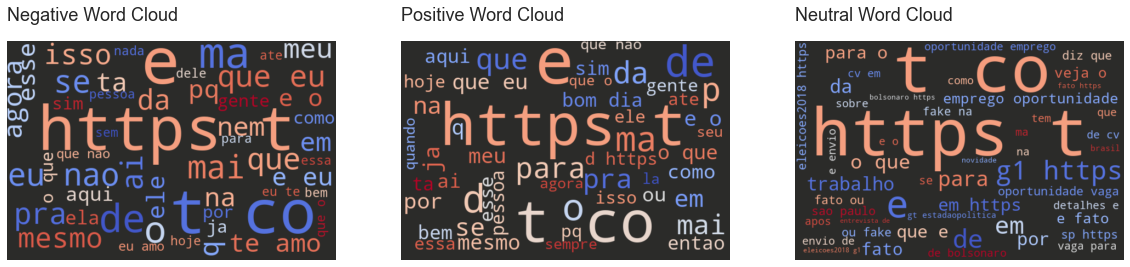

In [15]:
plot_word_cloud(baseline_df, 'tweet_text')

## Pareto Chart

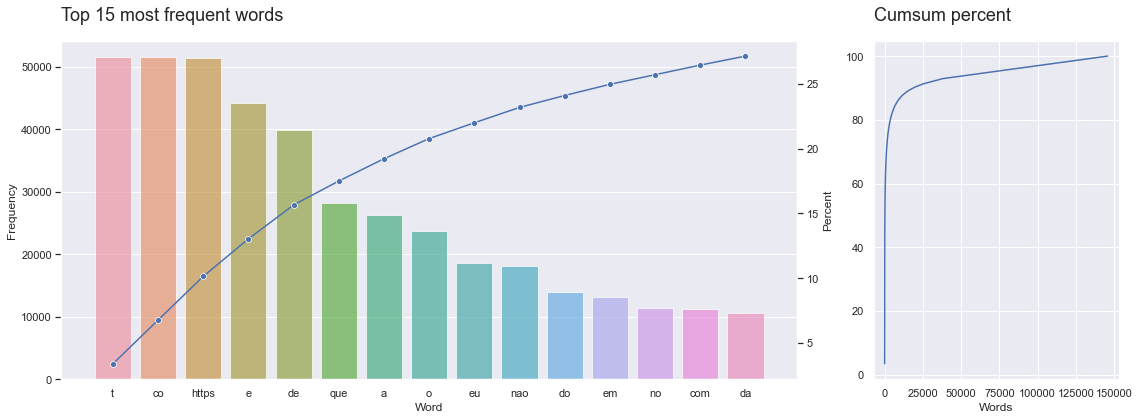

In [16]:
pareto_chart(baseline_df['tweet_text'])

## Split data into train/test

In [62]:
from sklearn.model_selection import train_test_split

X = baseline_df['tweet_text']
y = baseline_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

baseline_word_length = len(pd.concat([X_train, X_test]).str.cat())

## Pre-processing

Creating a **bag of words** with [`CountVectorizer`](#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), and build sklearn `Pipeline` with `LogisticRegression` model. 

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(max_iter=1000,random_state=42))
])

clf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('lr', LogisticRegression(max_iter=1000, random_state=42))])

## Metrics report

In [64]:
# Calculate metrics and display
train_test_metrics(X_train,X_test, y_train, y_test, clf_pipeline)

Train dataset:
ROC AUC Score = 0.980
F1 Score = 0.915
Test dataset:
ROC AUC Score = 0.936
F1 Score = 0.813


# Second Cycle - Improving Model with Feature Engineering

## Split data into train/test

In [68]:
# Prepare data
X = df['tweet_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Apply Feature Engineering

In [47]:
cols_to_drop = ['id', 'tweet_date', 'query_used']

# Create Pre-process Pipeline
feat_pipeline = Pipeline([
                    ('feat_eng', FeaturesCreator()),
                    ('column_dropper', ColumnDropper(cols_to_drop))
                ]).fit(X_train, y_train)

# Transform features
X_train = feat_pipeline.transform(X_train)
X_test = feat_pipeline.transform(X_test)

feat_model_word_length = len(pd.concat([X_train, X_test]).str.cat())

Processing emojis...
Removing stopwords...


100%|█████████████████████████████████| 76000/76000 [00:00<00:00, 177606.22it/s]


Feature Engineering complete!
Processing emojis...
Removing stopwords...


100%|█████████████████████████████████| 19000/19000 [00:00<00:00, 135565.04it/s]


Feature Engineering complete!


## Fit model and calulate metrics

In [70]:
# Create Pipeline and fit model
clf_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(max_iter=1000,random_state=42))
]).fit(X_train, y_train)

# Calculate metrics and display
train_test_metrics(X_train,X_test, y_train, y_test, clf_pipeline)

Train dataset:
ROC AUC Score = 0.959
F1 Score = 0.865
Test dataset:
ROC AUC Score = 0.913
F1 Score = 0.775


## Visualize with Word Cloud and Pareto Chart

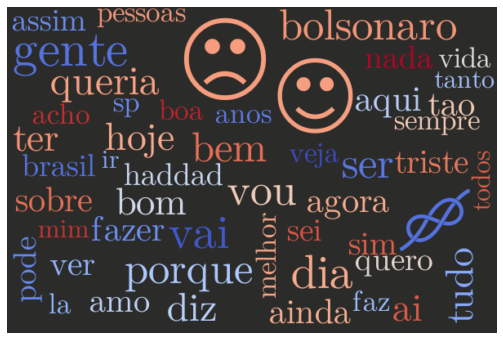

In [71]:
feat_eng_words = ' '.join(text for text in pd.concat([X_train, X_test]))
# Calculate word frequencies
feat_eng_words_freq = Counter(feat_eng_words.split())

# Create Word Cloud
word_cloud = WordCloud(
                font_path='data/Symbola.otf',
                max_words=50,
                width=600, 
                height=400,
                background_color='#2b2b29',
                colormap='coolwarm',
                max_font_size = 120,
                random_state=42
                ).generate_from_frequencies(feat_eng_words_freq)
# Display image
plt.figure(figsize=(12,6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.grid(False)
plt.axis('off');

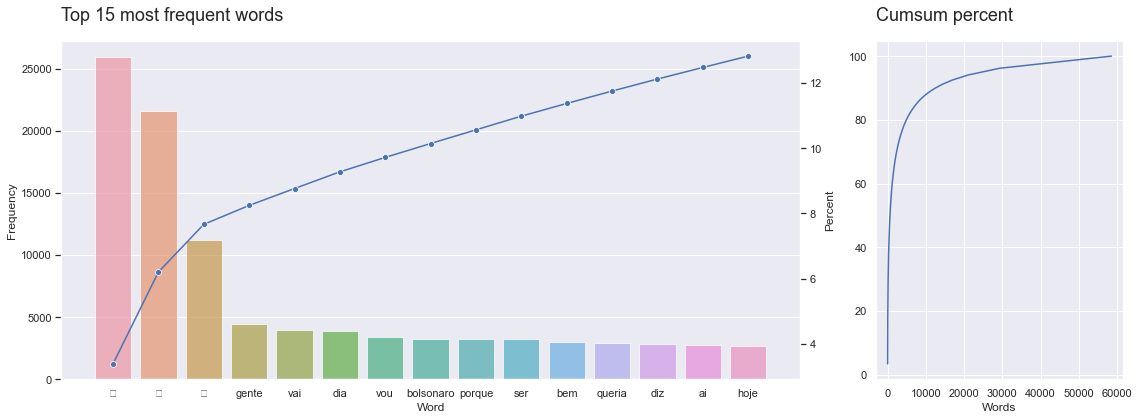

In [72]:
with warnings.catch_warnings(record=True):     # Hide matplotlib font warning
    pareto_chart(pd.concat([X_train, X_test]))

## Discussion

| Metrics 	| Baseline 	| Model with F.E. 	|
|:---	|:---	|:---	|
| Train ROC AUC 	| 0.995 	| 0.978 	|
| Train F1 	| 0.967 	| 0.903 	|
| Test ROC AUC 	| 0.938 	| 0.907 	|
| Test F1 	| 0.825 	| 0.770 	|  

Despite cleaning the data, model with feature engineering had a lower performance than the baseline.   
Maybe some characters like the emojis 🙂 and 🙁 are introducing bias. Also, some valuable information was lost when applying feature engineering steps, like removing the custom stopwords, or just because the amount of data lost was considerable.    

In [73]:
data_loss = ((feat_model_word_length / baseline_word_length) - 1) * 100
print(f'Percentage of data loss from applying feature engineering: {-data_loss:.3f} %')

Percentage of data loss from applying feature engineering: 42.878 %


In the next step we can try different methods for both baseline an feature engineered model, such as RandomForest,  

# Third Cycle - Trying other estimators

## Random Forest

The `RandomForestClassifier` estimator is more powerfull than `Logistic Regression`, for using the concept of *Bagging*(Bootsrap Aggregating) to generate random independent trees and make the final prediction throught the average of each individual prediction.  
  
This approach tends to remove some erros and outliers, making a model more generic an stable to overfitting.  
The most important parameters are:  
- `n_estimators`: how many trees will be build. More trees will take a longer time to finish, and starts to loses its individual properties.  
- `max_features`: number of features in the random sample to be used in each split. Less imply to reduce overfitting, but can lead to underfitting.  


## Gradient Boosting

## Support Vector Machine

In [ ]:
from sklearn.linear_model import SGDClassifier

## Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

## XGBoost

# Model optimization with Hyperparameter tunning

## Optmized search with `hyperopt`

A quickly method to find better hyper-parameters is performing search with [`hyperopt`](#http://hyperopt.github.io/hyperopt/) library.  
This algorithm uses bayesian optimization to improve the results.  

In [74]:
# hyperopt imports
from hyperopt import Trials, hp, tpe, fmin, space_eval
# cross validate method to be used with hyperopt
from sklearn.model_selection import cross_validate

Steps:  
- Create our **hps_space**, a dictionary with every hyper-parameter and possible range of values  
- Define our objective function, it will contain our *pipeline*, *cross-validation transformer* and returns a *score*  
- Run the function with `fmin()`  
- Evaluate results with `space_eval()` 

In [93]:
# Model settings
estimator = LogisticRegression
estimator_params = {
    'C'        : np.logspace(-2, 2, 50),
    'l1_ratio' : np.linspace(0,1,10),
    'penalty'  : ['elasticnet'],
    'solver'   : ['saga'],
    'max_iter' : [100,200,300,400,500],
}
pp_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])
X = X_train
y = y_train
metric = 'roc_auc'
max_evals = 10

In [96]:
# Create hyper-parameter space
hps_space = create_hps_space(estimator_params)

# Create objective function
objective_function = create_fmin_function(
                            estimator=estimator, 
                            pp_pipeline=pp_pipeline,
                            X=X, y=y,
                            metric=metric,
                            hps_space=hps_space)

# Run hyper-parameter search
hps_search = fmin(fn=objective_function, 
                  space=hps_space, 
                  algo=tpe.suggest, 
                  trials=Trials(), 
                  rstate=np.random.default_rng(42),
                  max_evals=max_evals,
                  verbose=10)

  0%|                                    | 0/10 [04:42<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

## Best model metrics

In [ ]:
# Get results
hps_best_params = space_eval(hps_space, hps_search)
print(f'{CYAN}{estimator.__name__}{WHITE} best parameters:')
for key, value in hps_best_params.items():
        print(f'{GREEN}', key, f'{WHITE}', value)

# Create new pipeline with the best parameters
hps_model = Pipeline(
                [
                    ('pp', pre_processing_pipeline),
                    ('est', estimator(**hps_best_params, random_state=42))
                ]
        ).fit(X_train, y_train)

# Print results
print(f'\nScore for best model with hyperopt:')
display_metrics(X_train, X_test, y_train, y_test, hps_model, metric_type)

## Saving model with `pickle`

In [ ]:
pickle_path = 'models/'

# save file
with open(pickle_path + f'{estimator.__name__}.pickle', 'wb') as file:
    pickle.dump(hps_model, file, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'File saved on {os.path.realpath(file.name)}')

# Interpreting model results

In [104]:
!ls -la

total 35904
drwxr-xr-x@ 10 baiochi  staff      320 May 23 20:04 .
drwxr-xr-x@  8 baiochi  staff      256 May 18 20:17 ..
-rw-------@  1 baiochi  staff    10244 May 23 12:35 .DS_Store
drwxr-xr-x@  4 baiochi  staff      128 May 23 00:16 .ipynb_checkpoints
-rw-------@  1 baiochi  staff  9988348 May 23 20:03 Machine Learning.ipynb
-rw-------@  1 baiochi  staff  4701586 May 23 19:07 Project_notebook.ipynb
drwxr-xr-x@  8 baiochi  staff      256 May 22 15:30 data
-rw-------   1 baiochi  staff        1 May 23 20:04 requirements.txt
drwxr-xr-x@  4 baiochi  staff      128 May  6 00:52 styles
-rw-------@  1 baiochi  staff  3672724 May 23 14:27 temp-plot.html


In [109]:
!pip install session-info

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 1.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8045 sha256=ad38cc512a58441f30d8490b8f8a81d14245dba0e1c2be68a160b0ea928353ef
  Stored in directory: /Users/baiochi/Library/Caches/pip/wheels/d4/fc/2e/00ca60bac7954b84907efd41baa9b4853500eaeec4228410c6
Successfully built session-info


In [115]:
import session_info

session_info.show()

In [116]:
!python --version

Python 3.9.7
